# Jack’s Car Rental

---
A solution to Jack's car rental problem

In [334]:
import jax
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from jax import random
from tensorflow_probability.substrates import jax as tfp

In [259]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [228]:
# Discount rate
γ = 0.9
# Rate of request
λ_req_a, λ_req_b = 3, 4
# Rate of return
λ_ret_a, λ_ret_b = 3, 2

# Maximum number of cars allowed at any location
max_cars = 20
# Maximum number of cars that are allowed to be moved overnight
max_car_move = 5

# MDP:
# timestep: days
# state: number of cars at each location at the end of the day
# actions: net number of cars moved between the two locations overnight

To solve this problem, we must first determine the grid of possible values given by

$$
    p(s'_a, s'_b, r \vert s_a, s_b, a)
$$

* $\mathcal A = \{-5, -4, \ldots, 5\}$
* $\mathcal R = \left\{10, -2n\right\}$, where $n$ is the number of cars moved overnight

## Some experiments

In [246]:
S_a, S_b  = 10, 20

In [389]:
key = random.PRNGKey(314)

key_ret_a, key_req_a, key_ret_b, key_req_b = random.split(key, 4)

n_days = 500

returned_a = random.poisson(key_ret_a, λ_ret_a, (n_days,))
requested_a = random.poisson(key_req_a, λ_req_a, (n_days,))

returned_b = random.poisson(key_ret_b, λ_ret_b, (n_days,))
requested_b = random.poisson(key_req_b, λ_req_b, (n_days,))

In [390]:
def reduce_hist(state, xs):
    new_state = jnp.clip(state + xs, 0, 20)
    return new_state, new_state

### Inventory simulation

Assuming that there is no interaction between locations `a` and `b`, the following plot shows a simulation on the number of cars at each location at the end of the day.

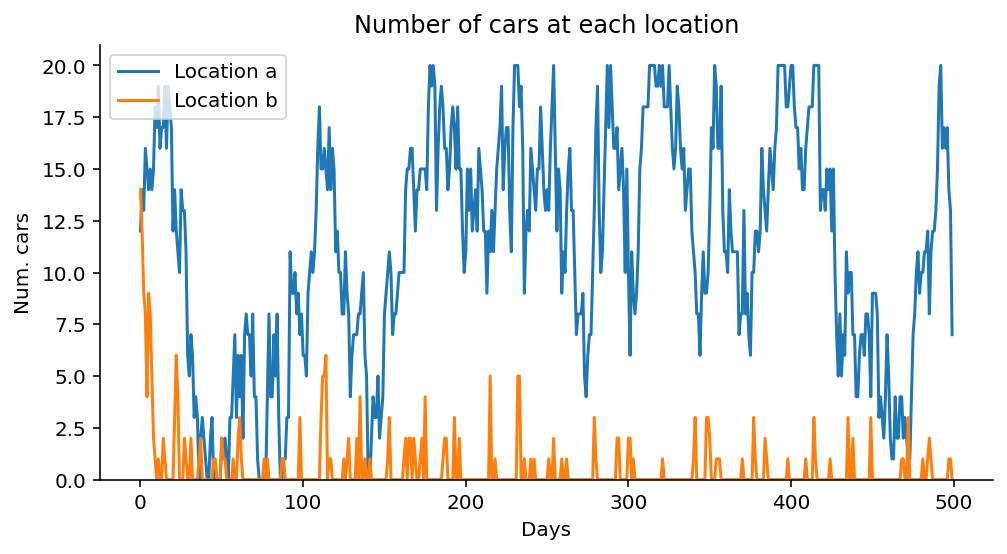

In [391]:
Δa = returned_a - requested_a
Δb = returned_b - requested_b

_, hist_a = jax.lax.scan(reduce_hist, S_a, Δa)
_, hist_b = jax.lax.scan(reduce_hist, S_b, Δb)

plt.subplots(1, 1, figsize=(8, 4))
plt.plot(hist_a, label="Location a")
plt.plot(hist_b, label="Location b")
plt.ylim(0, 21)
plt.legend()
plt.ylabel("Num. cars")
plt.xlabel("Days")
plt.title("Number of cars at each location");

## Computing probabilities

The claim is that

$$
    p(s_b' \vert s_b, a) = \text{Skellam}\left(s_b' - s_b -  a \vert \lambda_b^\text{ret}, \lambda_b^\text{req}\right) \mathbb{1}\big(0 \leq s_b' \leq 20\big)
$$

In [443]:
def prob_a(sa_prime, sa, action):
    dist = tfp.distributions.Skellam(λ_ret_a, λ_req_a)
    return dist.prob(sa_prime - sa - action) * (0 <= sa_prime) * (sa_prime <= 20)

In [444]:
sa = 3
a = 5

sa_prime_samp = sa + a + returned_a - requested_a
sa_prime_samp = (sa + a + returned_a - requested_a) * (0 <= sa_prime_samp) * (sa_prime_samp <= 20)

Computing the distribution of the number of cars at location `a` at the end of the day assuming that $s_a = 3$ and $a = 5$

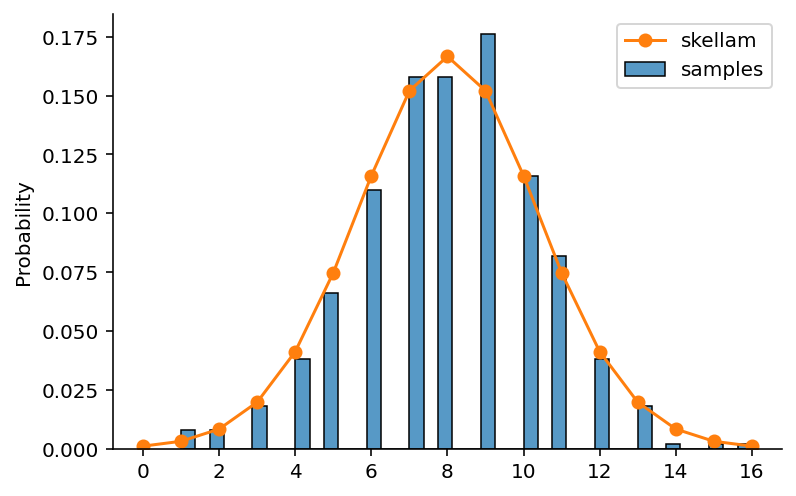

In [445]:
net_move_a = jnp.arange(0, 17).astype(float)

sns.histplot(sa_prime_samp, stat="probability", bins=40, label="samples")
plt.plot(net_move_a, prob_a(net_move_a, sa, a), c="tab:orange", marker="o", label="skellam")
plt.legend();

In [448]:
def prob_a(sa_prime, sa, action):
    """
    Probabiliy of moving `action` cars from location a -> location b
    """
    dist = tfp.distributions.Skellam(λ_ret_a, λ_req_a)
    return dist.prob(sa_prime - sa - action) * (0 <= sa_prime) * (sa_prime <= 20)

def prob_b(sb_prime, sb, action):
    """
    Probabiliy of moving `action` cars from location b -> location a
    """
    dist = tfp.distributions.Skellam(λ_ret_b, λ_req_b)
    return dist.prob(sb_prime - sb + action) * (0 <= sb_prime) * (sb_prime <= 20)

def p_move(action, sa, sb):
    return (sa >= action) * (sb >= -action)




In [438]:
sa = 1
sb = 0

actions = jnp.arange(-5, 6)
actions

DeviceArray([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5], dtype=int32)

In [439]:
for action in actions:
    val = p_move(action, sa, sb)
    print(f"{action:2}: {val}")

-5: False
-4: False
-3: False
-2: False
-1: False
 0: True
 1: True
 2: False
 3: False
 4: False
 5: False


In [456]:
def p_transition_a(returned, requested, state, action):
    state_prime = state + action + returned - requested
    dist = tfp.distributions.Skellam(λ_ret_a, λ_req_a)
    return dist.prob(returned - requested) * (0 >= state_prime) * (state_prime <= 20)

def p_transition_b(returned, requested, state, action):
    state_prime = state - action + returned - requested
    dist = tfp.distributions.Skellam(λ_ret_b, λ_req_b)
    return dist.prob(returned - requested) * (0 >= state_prime) * (state_prime <= 20)

def p_request_a(requested, state):
    dist = tfp.distributions.Poisson(λ_req_a)
    return dist.prob(requested) * (requested <= state )

def p_request_b(requested, state):
    dist = tfp.distributions.Poisson(λ_req_b)
    return dist.prob(requested) * (requested <= state )

def p_move(action, state_a, state_b):
    return (state_a >= action) * (state_b >= -action)

In [497]:
@jax.jit
def p(returned_a, returned_b, requested_a, requested_b,
      state_a, state_b, action):
    p_a = p_transition_a(returned_a, requested_a, state_a, action)
    p_b = p_transition_b(returned_b, requested_b, state_b, action)
    p_req_a = p_request_a(requested_a, state_a)
    p_req_b = p_request_b(requested_b, state_b)
    move_ind = p_move(action, state_a, state_b)
    
    return p_a * p_b * p_req_a * p_req_b * move_ind

In [493]:
arange = jnp.arange(-5, 5).astype(float)
vrange = jnp.arange(-20, 21).astype(float)

In [513]:
pv = jax.vmap(p, (0, None, None, None, None, None, None), out_axes=-1)
pv = jax.vmap(pv, (None, 0, None, None, None, None, None), out_axes=-1)
pv = jax.vmap(pv, (None, None, 0, None, None, None, None), out_axes=-1)
pv = jax.vmap(pv, (None, None, None, 0, None, None, None), out_axes=-1)
# pv = jax.vmap(pv, (None, None, None, None, 0, None, None))
# pv = jax.vmap(pv, (None, None, None, None, None, 0, None))
pv = jax.vmap(pv, (None, None, None, None, None, None, 0), out_axes=-1)

# returned a
# returned b
# requested a
# requested b
# state a
# state b
# action
p_grid = pv(vrange, vrange, vrange, vrange, 2.0, 2.0, arange)

In [515]:
p_grid.size

28257610

In [514]:
p_grid.shape

(41, 41, 41, 41, 10)

In [ ]:
sa, sb = 2.0, 10.0

jnp.einsum("ijkla,k,l,a->", p_grid, )

In [461]:
ret_a_range = jnp.arange(-20, 21)
ret_b_range = jnp.arange(-20, 21)
req_a_range = jnp.arange(-20, 21)
req_b_range = jnp.arange(-20, 21)